In [1]:
# ************* Importing ***************

# Importing all our needed libraries
from google.colab import drive
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
# Found as alternative to PCA when there is sparse input type
from sklearn.decomposition import TruncatedSVD
# Found this is a very common method of converting text features to usable numeric features and Sklearn has a handy function so we chose it
from sklearn.feature_extraction.text import TfidfVectorizer 
# Found to visualize the tree structures
import graphviz
from PIL import Image

# Setting up Google Drive connection
drive.mount('/content/drive/')

# Pathing to our project folder in Google Drive
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/CS254 - Final Project/Project/'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
#print(os.listdir(GOOGLE_DRIVE_PATH))

# Import our Dataset into pandas df
data = pd.read_csv(GOOGLE_DRIVE_PATH + "CS_254_Seeded_Dataset.csv")

# Test display of the dataset
#display(data.head())

Mounted at /content/drive/


In [2]:
# ************* Data Processing ***************

# Drop the ID column (always)
data = data.drop('Message ID', axis=1)

# **************Testing weights ******************
data = data.drop('Date', axis=1) # Removes date
# data = data.drop('Subject', axis=1) # Removes subject
# data = data.drop('Message', axis=1) # Removes body

# Split the dataset into features (X) and targets (y)
# Kept getting a value error due to NaN's in the data and while researching discovered this built in pandas function to fix
X = data.iloc[:, :-1].fillna("")
y = data.iloc[:, -1]

# Test display of X and y
display(X)
display(y)

# After researching multiple errors, a recommendation to fuse all text columns into one seemed to fix them.
# Apparently the number of features can get way too high when using tfidf otherwise
if len(data.columns) > 1:
  X = X.apply(' '.join, axis=1)

,Subject,Message
0,christmas tree farm pictures,
1,"vastar resources , inc .","gary , production from the high island larger ..."
2,calpine daily gas nomination,- calpine daily gas nomination 1 . doc
3,re : issue,fyi - see note below - already done .\nstella\...
4,meter 7268 nov allocation,fyi .\n- - - - - - - - - - - - - - - - - - - -...
...,...,...
33823,CLICK NOW,"Dear user, This is to notify all Students and ..."
33824,An Imperative Task,Hi\r\n\r\nIs your schedule open today? I’m hea...
33825,Colin Fitzgerald,Are you available? I have a request I need you...
33826,CLICK NOW,"Dear user, This is to notify all Students and ..."


0        0
1        0
2        0
3        0
4        0
        ..
33823    1
33824    1
33825    1
33826    1
33827    1
Name: Spam, Length: 33828, dtype: int64

In [3]:
# ************* Create Numerical Features ***************

# Convert text features to numeric features using sklearn TFIDF vectorizer
tfidf = TfidfVectorizer()
X_vectorized = tfidf.fit_transform(X)

In [4]:
# ************* Splitting and Training ***************
# These are just standard tests to make sure the code to make and use the models work

# Split the dataset into training and testing sets
t_size = .30
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=t_size, random_state=42376)

# Tuning Variables:
max_iter = 500
max_depth = 30
n_estimators = 50


# Create classifiers in an iteratable python dictionary for the for loop
models = {
    "Logistic Regression Classifier": LogisticRegression(max_iter=max_iter),
    "Decision Tree Classifier": DecisionTreeClassifier(max_depth=max_depth),
    "Random Forest Classifier": RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
}

# Confirm valid and compatible shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)


# Loop through the models, fit them, and calculate their accuracy
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} accuracy: {accuracy:.5f}")

X_train shape: (23679, 158516)
y_train shape: (23679,)
Logistic Regression Classifier accuracy: 0.98217
Decision Tree Classifier accuracy: 0.95241
Random Forest Classifier accuracy: 0.95576


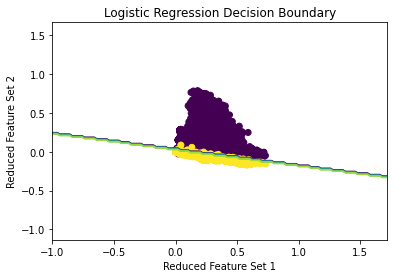

In [5]:
# ************* Plotting ***************

# It took a lot of trial and error to get this plot working, and I think it sadly,
# just isn't very helpful due to the hyperdimensiality of our TF-IDF features.

# Reduce the data into a 2D so we can plot it
# PCA was attempted but apparently it can not work on sparse input type
# SVD was offered online as a substitute for PCA when you have sparse input type
svd = TruncatedSVD(n_components=2)
X_svd = svd.fit_transform(X_train)

svd = TruncatedSVD(n_components=2)
X_full_svd = svd.fit_transform(X_vectorized)

# Train the logistic regression model on the 2D dataset
log_reg = LogisticRegression(max_iter=max_iter)
log_reg.fit(X_svd, y_train)

# Create a mesh grid for the decision boundary plot
h = .02
x_min, x_max = X_svd[:, 0].min() - 1, X_svd[:, 0].max() + 1
y_min, y_max = X_svd[:, 1].min() - 1, X_svd[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Calculate the decision boundary
Z = log_reg.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.contour(xx, yy, Z)
plt.scatter(X_full_svd[:, 0], X_full_svd[:, 1], c=y, cmap='viridis')

# Add axis labels and a title
plt.xlabel('Reduced Feature Set 1')
plt.ylabel('Reduced Feature Set 2')
plt.title('Logistic Regression Decision Boundary')

# Display the plot
plt.show()

In [6]:
# ************* Tree Visualizing Graphs ***************

sorted_by_weight_HtL = np.argsort(models['Decision Tree Classifier'].feature_importances_)[::-1]
sorted_top_10 = sorted_by_weight_HtL[:10]

# Check what the key words are
for word in sorted_top_10:
  print(tfidf.get_feature_names_out()[word])

enron
2001
attached
hourahead
vince
thanks
http
gas
louise
your


In [7]:
# Create visualized structure of decision tree and display it ** THIS WILL BE HUGE / TAKE TIME TO GEN ** CMD/CTRL & - until you can see the structure **
dtmodel = export_graphviz(models['Decision Tree Classifier'], out_file=None, filled=True, rounded=True, class_names=['0', '1'])
graph = graphviz.Source(dtmodel)
graph.render('decision_tree', format='png')
import cv2
from google.colab.patches import cv2_imshow
# Read the image using OpenCV
img = cv2.imread('decision_tree.png')
cv2.resize(img, (1600, 1200))

# Display the image
cv2_imshow(img)


# I wanted to see if I could visual the random forest but the image was easily over 10GB in size and could not be displayed

Output hidden; open in https://colab.research.google.com to view.

In [10]:
log_array = np.zeros(19)
dt_array = np.zeros(19)
rf_array = np.zeros(19)
index = 0

for i in range(5, 100, 5):
    t_size = ((100 - i)/100)
    print(f"{100 - i}% left to go")
    X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=t_size, random_state=42376)

    # Create classifiers in an iteratable python dictionary for the for loop
    models = {
      "Logistic Regression Classifier": LogisticRegression(max_iter=max_iter),
      "Decision Tree Classifier": DecisionTreeClassifier(max_depth=max_depth),
      "Random Forest Classifier": RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    }

    # Loop through the models, fit them, and calculate their accuracy
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='micro')
        if model_name == "Logistic Regression Classifier":
            log_array[index] = f1
        if model_name == "Decision Tree Classifier":
            dt_array[index] = f1
        if model_name == "Random Forest Classifier":
            rf_array[index] = f1
    index+=1
    
display(log_array)
display(dt_array)
display(rf_array)

95% left to go
90% left to go
85% left to go
80% left to go
75% left to go
70% left to go
65% left to go
60% left to go
55% left to go
50% left to go
45% left to go
40% left to go
35% left to go
30% left to go
25% left to go
20% left to go
15% left to go
10% left to go
5% left to go


array([0.96281545, 0.96948696, 0.97322112, 0.97605587, 0.97686335,
       0.97749155, 0.97962618, 0.98103168, 0.98183382, 0.98226321,
       0.98252644, 0.98241206, 0.98226351, 0.98216573, 0.98261795,
       0.98226426, 0.98187192, 0.98019509, 0.97813239])

array([0.88872639, 0.92626289, 0.93047924, 0.93592728, 0.94221749,
       0.94375   , 0.94051571, 0.94127211, 0.94872622, 0.95169682,
       0.95158642, 0.94982264, 0.95194257, 0.95309883, 0.95282015,
       0.95373928, 0.95093596, 0.95033993, 0.94917258])

array([0.95245356, 0.94826907, 0.95419768, 0.95643499, 0.95376611,
       0.95101351, 0.95606894, 0.95738286, 0.95936795, 0.95678136,
       0.95618472, 0.96046409, 0.95920608, 0.95575919, 0.95849592,
       0.95580845, 0.95349754, 0.94324564, 0.94621749])

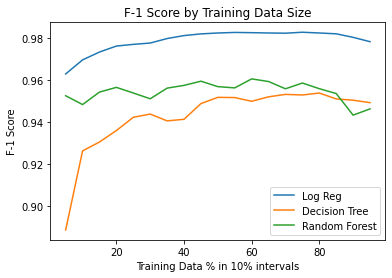

In [12]:
# Shift the index values by 1 to like up with x0%
x = np.arange(5, 100, 5)

# Plot all three arrays
plt.plot(x, log_array, label='Log Reg')
plt.plot(x, dt_array, label='Decision Tree')
plt.plot(x, rf_array, label='Random Forest')

# Add legend and axis labels
plt.legend()
plt.xlabel('Training Data % in 10% intervals')
plt.ylabel('F-1 Score')
plt.title('F-1 Score by Training Data Size')

# Show the plot
plt.show()

In [ ]:
# ************* Cross - Val Testing and Hyperparam tweaking ***************

# for i in range(100):
  # scores = cross_val_score()